## 1. 数据预处理

In [1]:
import numpy as np
import scipy.io
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 数据读取函数定义  
注： mat 文件数据结构见 BatteryDataset 下的 txt 文件

In [2]:
def TimeConvert(hmm):
    """ 
        转换时间格式，将字符串转换成 datatime 格式  
    Args:
        hmm: 待输入的原始时间数据 (ndarray)
    Returns:
        标准化后的时间数据
    """
    year, month, day, hour, minute, second = \
                int(hmm[0]), int(hmm[1]), int(hmm[2]), \
                int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, 
                    hour=hour, minute=minute, second=second)

def LoadMat(mat_file):
    """ 
        加载 mat 文件数据  
    Args:
        mat_file: 待加载的文件路径 (string)
    Returns:
        读取的数据 (list)，其中每个元素为一个嵌套的 dict 类型
    """
    # 函数返回一个字典，其中键是 mat 文件中变量的名称，值是对应的数据数组
    data = scipy.io.loadmat(mat_file)
    # 从文件路径中提取文件名(不包含扩展名),用于访问字典的值
    fileName = mat_file.split('/')[-1].split('.')[0]
    col = data[fileName] # 获取整个数据(一个(1 x N)的四层结构化数组)
    col = col[0][0][0][0] # 去除冗余维度，访问包含所有循环数据的(616,)结构化数组
    size = col.shape[0] # 获取数组的大小(cycle 的数量)
    # print("data['B0005'].dtype:",data['B0005'].dtype,"value:",data['B0005'])
    # print("data['B0005'][0][0][0][0].dtype:",data['B0005'][0][0][0][0].dtype,
    #       "value:",data['B0005'][0][0][0][0])
    # print("data['B0005'][0][0][0][0][0][3][0].dtype:",data['B0005'][0][0][0][0][0][3][0].dtype,
    #       "value:",data['B0005'][0][0][0][0][0][3][0])

    data = []
    for i in range(size): # 遍历每个 cycle 的数据
        """ dtype.fields 方法用于访问 NumPy 结构化数组的字段信息，它返回一个字典，其中：
        键: 是结构化数组中每个字段的名称（字符串）；
        值: 是描述每个字段的元组，包含字段的数据类型、字节偏移量以及可选的标题。 """
        k = list(col[i][3][0].dtype.fields.keys()) # 获取结构化数组(data 字段)中所有子字段名称的列表
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance': # 去除 impedance 类型的数据
            for j in range(len(k)): # 遍历(data 字段)数组中的每个子字段
                t = col[i][3][0][0][j][0] # 获取该字段的数组数据
                l = [t[m] for m in range(len(t))] # 遍历提取数组中每个数据转为列表
                d2[k[j]] = l # 保存该数据及其对应的字段名称(以键值对的形式存在)
        # 将每个样本(cycle)的类型、温度、时间和数据存储到字典 d1 中
        d1['type'], d1['temp'], d1['time'], d1['data'] = \
            str(col[i][0][0]), int(col[i][1][0]), str(TimeConvert(col[i][2][0])), d2
        data.append(d1)

    return data

def GetBatteryCapacity(Battery):
    """ 
        获取单个锂电池的容量数据  
    Args:
        Battery: 单个电池的数据 (dict)
    Returns:
        获取的电池容量数据 (list)，包含两个元素，第一个为放电周期，第二个为容量数据
    """
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge': # 放电状态下获取容量数据
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

def GetBatteryValues(Battery, Type='charge'):
    """ 
        获取单个锂电池充电或放电时的测试数据(默认为充电状态的数据)  
    Args:
        Battery: 单个电池的数据 (dict)
        Type: 指定要读取的数据类型 (string)
    Returns:
        获取的电池数据， list 类型
    """
    data = []
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [3]:
# 用于测试数据
# Battery_list = 'B0005'
# dir_path = r'BatteryDataset/'

# path = dir_path + Battery_list + '.mat'
# data = LoadMat(path)

### 1.2 读取数据

In [4]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = r'BatteryDataset/'

capacity, charge, discharge = {}, {}, {}
for name in Battery_list:
    print('Loading Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = LoadMat(path)
    capacity[name] = GetBatteryCapacity(data) # 放电时的容量数据
    charge[name] = GetBatteryValues(data, 'charge') # 充电数据
    discharge[name] = GetBatteryValues(data, 'discharge') # 放电数据

Loading Dataset B0005.mat ...
Loading Dataset B0006.mat ...
Loading Dataset B0007.mat ...
Loading Dataset B0018.mat ...


### 1.3 数据展示

#### 1.3.1 不同电池容量 vs. 充放电周期曲线

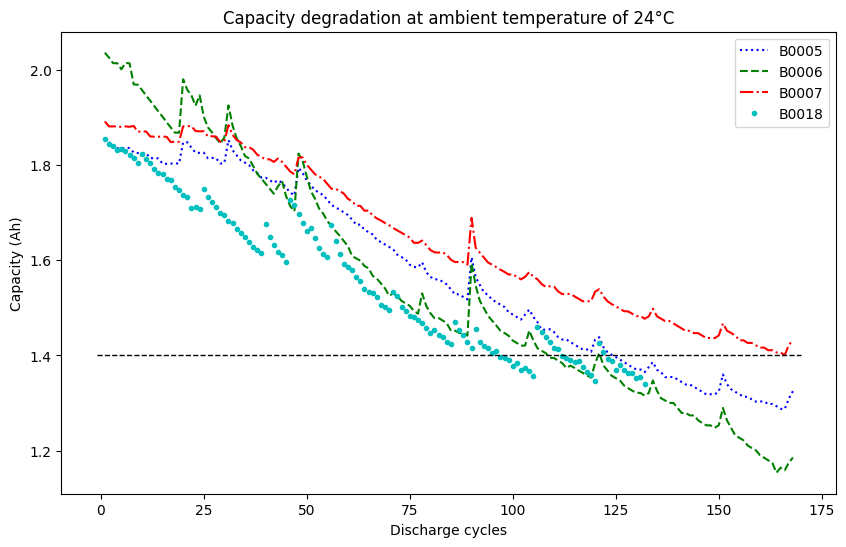

In [5]:
fig, ax = plt.subplots(1, figsize=(10, 6))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = capacity[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
# 临界点直线(电池容量下降30%则认为报废)
plt.plot([-1,170],[2.0*0.7,2.0*0.7],c='black',lw=1,ls='--')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', 
       title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

#### 1.3.2 不同放电周期下，B0005号电池电压 vs. 放电周期曲线

[Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Voltage (V)'),
 Text(0.5, 1.0, 'Voltage vs. Time for Discharge Cycles')]

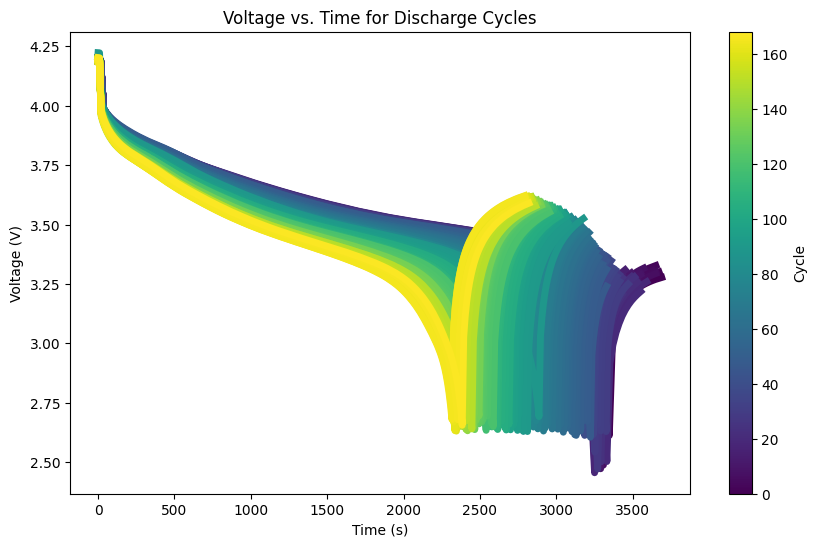

In [6]:
fig, ax = plt.subplots(1, figsize=(10, 6))
cmap = plt.get_cmap('viridis') # 选择合适的颜色映射, 'hsv', 'jet', 'viridis' 等

name = 'B0005' # 仅绘制第 B0005 号电池
for i, cycle_data in enumerate(discharge[name]):
    # 使用 plot 绘制，并根据循环次数着色
    ax.plot(cycle_data['Time'], cycle_data['Voltage_measured'], 
            c=cmap(i / len(discharge[name])), linewidth=5.0)
# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=plt.Normalize(vmin=0, vmax=len(discharge[name])))
sm.set_array([])  # 这是为了让colorbar工作，即使没有明确的映射数组
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cycle') # 添加颜色条标签

ax.set(xlabel='Time (s)', ylabel='Voltage (V)', 
       title='Voltage vs. Time for Discharge Cycles')

#### 1.3.3 不同放电周期下，B0005号电池电流 vs. 充电周期曲线

[Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Current (V)'),
 Text(0.5, 1.0, 'Current vs. Time for discharge Cycles')]

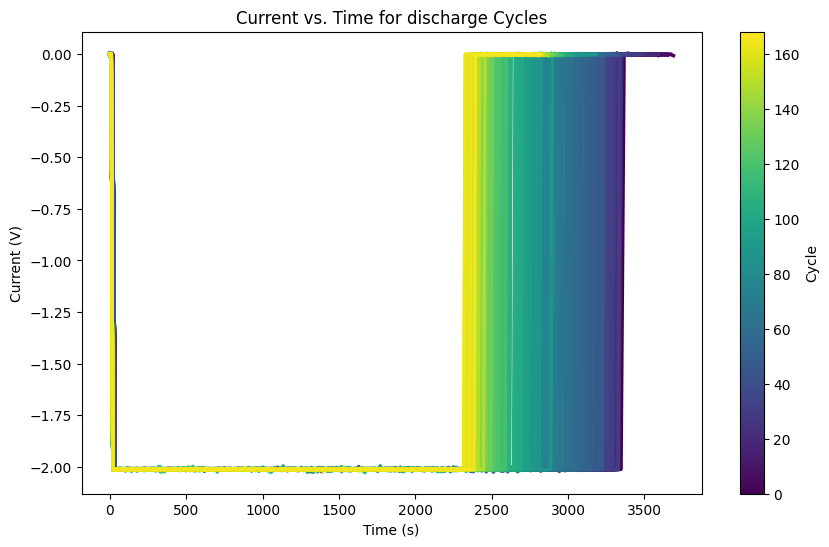

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 6))
cmap = plt.get_cmap('viridis') # 选择合适的颜色映射, 'hsv', 'jet', 'viridis' 等

name = 'B0005' # 仅绘制第 B0005 号电池
for i, cycle_data in enumerate(discharge[name]):
    # 使用 plot 绘制，并根据循环次数着色
    ax.plot(cycle_data['Time'], cycle_data['Current_measured'], 
            c=cmap(i / len(charge[name])), linewidth=2.5)
# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=plt.Normalize(vmin=0, vmax=len(discharge[name])))
sm.set_array([])  # 这是为了让colorbar工作，即使没有明确的映射数组
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cycle') # 添加颜色条标签

ax.set(xlabel='Time (s)', ylabel='Current (V)', 
       title='Current vs. Time for discharge Cycles')

### 1.4 创建数据集

#### 1.4.1 数据集类定义

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from math import sqrt
import random
import os
import math
import copy
# 注册设备
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [9]:
# 定义数据集类
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, pred_len=1):
        self.window_size = window_size
        self.pred_len = pred_len
        self.data = torch.tensor(data, dtype=torch.float32).to(device)
        # 计算最大索引
        self.max_index = self.data.shape[0] - self.window_size - pred_len

    def __len__(self):
        return self.max_index + 1 #  返回有效数据长度

    def __getitem__(self, index):
        if index > self.max_index:
            raise IndexError(f"Index {index} is out of bounds."
                            f"Max index is {self.max_index}")
        source = self.data[index:index + self.window_size]
        target = self.data[index + 1:index + self.window_size + 1] # 向后偏移一个时间步
        return source.unsqueeze(1), target.unsqueeze(1) # 添加一个特征维度

#### 1.4.2 数据集获取函数定义

In [10]:
# 生成自回归掩码张量
def gen_subsequent_mask(size, n_head):
    """ 
        生成向后遮掩的掩码张量, 1代表不被遮掩, 0代表被遮掩
    Args:
        size: 掩码张量最后两个维度的大小
    Return:
        生成的掩码张量(下三角为1, 上三角为0)
     """
    # 定义张量大小
    mask_shape = (n_head, size, size)
    # 生成上三角矩阵并转为 uint8 以节省空间
    subsequent_mask = np.triu(np.ones(mask_shape), k=1).astype('uint8')
    # 反转上三角矩阵并转为 tensor
    return torch.from_numpy(1 - subsequent_mask).bool()

def get_data(data_dict, name, head=4, window_size=8, shuffle=True, batch_size=32):
    """ 
        留一法获取训练集和测试集 DataLoader, 每次留一个电池的数据作为测试集
    Args:  
        data_dict: 字典类型，键为电池名称，值为包含电池信息的元组，
                    其中第二个元素是容量数据列表 (list)
        name: 指定为测试集的电池数据名称 (str)
        head: 多头注意力的头数 (int)
        window_size: 用于创建时间序列的窗口大小 (int)
        shuffle: 是否打乱训练集 (bool)
        batch_size: 训练的批大小 (int)
    Returns:
        包含源数据和目标数据的 DataLoader 以及源数据和目标数据的掩码张量
    """
    test_data = data_dict[name][1]
    test_dataset = TimeSeriesDataset(test_data, window_size)

    train_datasets = []
    for k, v in data_dict.items():
        if k != name:
            dataset = TimeSeriesDataset(v[1], window_size)
            train_datasets.append(dataset)
    train_dataset = ConcatDataset(train_datasets) # 使用 ConcatDataset 拼接多个数据集

    # 创建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    src_mask = torch.ones((head, window_size, window_size), device=device).bool()
    tgt_mask = gen_subsequent_mask(window_size, head).to(device)

    # # # 打印 DataLoader
    # # print("train_loader_num:", len(train_loader.dataset))
    # # print("test_loader_num:", len(test_loader.dataset))
    # for src, tgt in train_loader:
    #     # print("src:", src.shape) # 输出: src: (batch_size, window_size, num_features)
    #     # print("tgt:", tgt.shape) # 输出: tgt: (batch_size, window_size, num_features)
    #     print("y:", tgt[:,-1]) # 输出: y: (batch_size, 1, num_features)
    #     break
    # # print("src_mask:", src_mask.shape) # 输出: src_mask: (head, window_size, window_size)
    # # print("tgt_mask:", tgt_mask.shape) # 输出: src_mask: (head, window_size, window_size)
    return train_loader, test_loader, src_mask, tgt_mask

In [11]:
# for i in range(len(Battery_list)):
#     name = Battery_list[i]
#     get_data(capacity, name)

## 2. 模型建立

In [12]:
# 定义克隆函数
def clones(module, N):
    """ 
        用于生成相同网络层的克隆函数
    Args:
        module: 需要克隆的目标网络层
        N: 要克隆的数量
    Return:
        返回一个具有相同网络层的 ModuleList 类型的列表
     """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# 计算注意力张量
def attention(query, key, value, mask=None, dropout=None):
    """ 
        计算注意力张量，当 query=key=value 时，则为自注意力机制
    Args:
        query: 输入的 query 张量
        key: 输入的 key 张量
        value: 输入的 value 张量
        mask: 输入的掩码张量
        dropout: 输入的 dropout 实例化对象
    Return:
        计算得到的 query 注意力表示和对应的注意力张量 p_attn
     """
    # 先取 query 最后一维的大小，一般为词嵌入维度
    d_k = query.size(-1)
    # 按照公式， query 与 key 的转置(这里使用 transpose 交换最后两个维度)相乘，在除以缩放系数
    # scores = scores - scores.max(dim=-1, keepdim=True)[0]  # 数值稳定性
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    # 判断是否使用掩码张量
    if mask is not None:
        # 使用 masked_fill 方法，将掩码张量和 scores 张量的每个位置进行比较
        # 如果对应掩码张量处为False，则使用一个很小的值(-1e9)进行替换
        scores = scores.masked_fill(mask==False, -1e9)

    # 对 scores 的最后一维进行 softmax 操作，得到最终的注意力张量
    p_attn = F.softmax(scores, dim=-1)

    # 判断是否进行随机'丢弃'
    if dropout is not None:
        p_attn = dropout(p_attn)

    # 最后，按照公式将注意力张量 p_attn 与 value 张量相乘得到最终的 query 注意力表示
    return torch.matmul(p_attn, value), p_attn

# 定义降噪自编码类
class Autoencoder(nn.Module):
    def __init__(self, input_size, auto_hidden, noise_level=0.01):
        """ 
            类初始化函数
        Args:
            input_size: 输入的特征维度
            hidden_ae: 隐藏维度
            noise_level: 噪声等级
        Return:
            None.
         """
        super(Autoencoder, self).__init__()
        # 传入参数
        self.input_size = input_size
        self.auto_hidden = auto_hidden
        self.noise_level = noise_level
        # 定义线性层
        self.fc1 = nn.Linear(self.input_size, self.auto_hidden)
        self.fc2 = nn.Linear(self.auto_hidden, self.input_size)

    def encoder(self, x):
        """ 
            编码函数
            Args:
                x: 输入张量表示
            Return:
                编码后的张量
         """
        h1 = F.relu(self.fc1(x))
        return h1

    def mask(self, x):
        """ 
            噪声掩码函数
            Args:
                x: 输入张量表示
            Return:
                编码后的张量
         """
        # 添加噪声
        corrupted_x = x + self.noise_level * torch.randn_like(x)
        return corrupted_x

    def decoder(self, x):
        """ 
            解码函数
            Args:
                x: 输入张量表示
            Return:
                解码后的张量
         """
        h2 = self.fc2(x)
        return h2

    def forward(self, x):
        """ 
            前向传播函数
            Args:
                x: 输入张量表示
            Return:
                编码和解码后的张量
         """
        out = self.mask(x)
        encode = self.encoder(out)
        decode = self.decoder(encode)
        return encode, decode

# 定义输入层类
class InputLayer(nn.Module):
    def __init__(self, features, d_model, noise_level=0.01, is_autoencoder=True):
        """ 
            类初始化函数
        Args:
            features: 输入的特征维度
            d_model: 输出的词嵌入维度
            batch_size: 批训练大小
        Return:
            None.
         """
        super(InputLayer, self).__init__()
        # 传入参数
        self.is_autoencoder = is_autoencoder
        self.noise_level = noise_level
        # 定义降噪自编码层
        self.autoencoder = Autoencoder(features, d_model, noise_level)

    def forward(self, x):
        """ 
            前向传播函数
            Args:
                x: 输入张量表示
            Return:
                计算后的张量
         """
        encode, decode = self.autoencoder(x)
        return encode if self.is_autoencoder else decode

# 定义位置编码类
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500):
        """ 
            类初始化函数
        Args:
            d_model: 词嵌入维度
            dropout: 置0比率
            max_len: 每个样本的最大长度
        Return:
            None.
         """
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(p=dropout)
        # 初始化一个位置编码矩阵 pe
        pe = torch.zeros(max_len, d_model)
        # 初始化一个绝对位置矩阵 position , 并拓展为 (max_len * 1) 的大小
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # 初始化一个大小为 (d_model * 1) 的变换矩阵, 产生一个递减频率
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        # 分别对位置编码矩阵 pe 的偶数列和奇数列进行编码
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 扩展维度以适应上一层的输出
        pe = pe.unsqueeze(0)
        # 注册位置编码矩阵 pe 为 buffer , 它不随模型的优化而改变
        self.register_buffer('pe', pe)

    def forward(self, x):
        """ 
            由于默认的 max_len 太大，使用 x.size(1) 以适配输入张量的大小；
            使用 Variable 对 pe 进行封装，使其与 x 的样式相同，但是不需要进行梯度求解
            Args:
                x: 序列张量表示
            Return:
                编码后的张量
         """
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

# 定义多头注意力机制类
class MutiHeadAttention(nn.Module):
    def __init__(self, n_head, embedding_dim, dropout=0.1):
        """ 
            类初始化函数
        Args:
            n_head: 多头注意力的头数
            embedding_dim: 词嵌入维度
            dropout: 置0比率
        Return:
            None.
         """
        super(MutiHeadAttention, self).__init__()
        # 判断模型维度 embedding_dim 能否被头数 n_head 整除
        assert embedding_dim % n_head == 0

        # 计算每个头的分割词向量维度
        self.d_k = embedding_dim // n_head
        
        self.n_head = n_head
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        # 克隆4个线性层的实例化对象，分别用于(Q, K, V) 以及 Concat
        self.linears = clones(nn.Linear(embedding_dim, embedding_dim), 4)
        
    def forward(self, query, key, value, mask=None):
        """ 
            前向传播函数
            Args:
                query: query 张量表示
                key: key 张量表示
                value: value 张量表示
                mask: 掩码张量表示, 默认为None
            Return:
                编码后的张量
         """
        # 判断是否存在掩码张量
        if mask is not None:
            # 扩展维度为4维
            mask = mask.unsqueeze(0)
        # 获取样本大小
        batch_size = query.size(0)
        # 使用 zip 方法对每个张量进行线性变换，然后使用 view 方法为每个头分割输入
        # 最后使用 transpose 方法将头的维度与序列长度的维度进行转置，使序列长度的维度与词向量维度相邻
        query, key, value = \
            [model(x).view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2) 
            for model, x in zip(self.linears, (query, key, value))]
        
        # 计算每个头的注意力张量
        x, self.attn = attention(query, key, value, mask, dropout=self.dropout)

        # 使用 transpose 方法将多头计算结果组成的4维张量进行逆转置
        # 然后使用 contiguous 方法和 view 方法重塑维输入形状
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_k)

        # 使用模型列表中的最后一个线性层对 x 进行线性变换得到最后的多头注意力输出
        return self.linears[-1](x)

# 位置编码的前馈全连接层类的定义
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        """ 
            类初始化函数
        Args:
            d_model: 词嵌入维度
            d_ff: 前馈全连接层的映射维度
            dropout: 置0比率
        Return:
            None.
         """
        super(PositionwiseFeedForward, self).__init__()
        # 定义两个线性层的实例对象
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        # 定义 dropout 的实例化对象
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        """ 
            前向传播函数
            Args:
                x: 输入张量表示
            Return:
                计算结果的张量
         """
        return self.w2(self.dropout(F.relu(self.w1(x))))
    
class NormLayer(nn.Module):
    def __init__(self, features, eps=1e-6):
        """ 
            类初始化函数
        Args:
            features: 词嵌入维度
            eps: 非常小的一个参数，用于防止计算时出现分母为零的情况
        Return:
            None.
         """
        super(NormLayer, self).__init__()

        # 定义两个分别为全1和全0的参数张量，对输入进行规范化操作
        # 但是为了不改变目标的原有表征，使用 Parameter 进行封装，使其成为模型参数的一部分
        self.parm1 = nn.Parameter(torch.ones(features))
        self.parm2 = nn.Parameter(torch.zeros(features))

        self.eps = eps

    def forward(self, x):
        """ 
            前向传播函数
            Args:
                x: 输入张量表示
            Return:
                计算结果的张量
         """
        # 在最后一个维度上对 x 求均值和标准差，并保持计算张量的维度，再根据规范化公式进行计算
        # 其中 parm1 为缩放参数， parm2 为偏置参数，*号和+号会自动对张量采用广播机制进行计算
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.parm1 * (x - mean) / (std + self.eps) + self.parm2
    
# 定义子层连接类
class SubLayerConnection(nn.Module):
    def __init__(self, size, dropout=0.1):
        """ 
            类初始化函数
        Args:
            size: 词嵌入维度
            dropout: 置0比率
        Return:
            None.
         """
        super(SubLayerConnection, self).__init__()
        # 定义规范化层的实例对象
        self.norm = NormLayer(size)
        # 定义 dropout 层的实例对象
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, sublayer):
        """ 
            前向传播函数
            Args:
                x: 输入张量表示
                sublayer: 子层连接中的子层函数
            Return:
                计算结果的张量
         """
        # 残差连接，使用输入 x 加上子层计算结果作为最终结果
        return x + self.dropout(self.norm(sublayer(x)))
    
# 定义编码器层类
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout=0.1):
        """ 
            类初始化函数
        Args:
            size: 词嵌入维度
            self_attn: 多头自注意力子层的实例化对象，自注意力即 Q=K=V
            feed_forward: 前馈全连接子层的实例化对象
            dropout: 置0比率
        Return:
            None.
         """
        super(EncoderLayer, self).__init__()

        self.size = size
        # 传入多头自注意力子层的实例化对象和前馈全连接子层的实例化对象
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        # 克隆2个子层连接对象
        self.sublayers = clones(SubLayerConnection(size, dropout=dropout), 2)

    def forward(self, x, mask=None):
        """ 
            前向传播函数
            Args:
                x: 输入张量表示
                mask: 输入的掩码张量
            Return:
                计算结果的张量
         """
        # 先通过第一个子层连接结构，其中包含多头自注意力子层
        # 再通过第二个子层连接结构，其中包含前馈连接子层
        x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayers[1](x, self.feed_forward)

# 定义编码器类
class Encoder(nn.Module):
    def __init__(self, layer, N):
        """ 
            类初始化函数
        Args:
            layer: 编码器层的实例化对象
            N: 编码器层的个数
        Return:
            None.
         """
        super(Encoder, self).__init__()
        # 克隆 N 个编码器层
        self.layers = clones(layer, N)
        # 定义一个规范化层
        self.norm = NormLayer(layer.size)

    def forward(self, x, mask=None):
        """ 
            前向传播函数
            Args:
                x: 输入张量表示
                mask: 输入的掩码张量
            Return:
                计算结果的张量
         """
        # 循环使用每个编码器层对输入张量 x 进行处理
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    
# 定义解码器层类
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout=0.1):
        """ 
            类初始化函数
        Args:
            size: 词嵌入维度
            self_attn: 多头自注意力子层的实例化对象，自注意力，即 Q=K=V
            src_attn: 多头注意力子层的实例化对象，注意力，即 Q!=K=V
            feed_forward: 前馈全连接子层的实例化对象
            dropout: 置0比率
        Return:
            None.
         """
        super(DecoderLayer, self).__init__()
        # 传入参数
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        # 克隆3个子层连接对象
        self.sublayers = clones(SubLayerConnection(size, dropout=dropout), 3)

    def forward(self, x, memory, source_mask=None, target_mask=None):
        """ 
            前向传播函数
            Args:
                x: 输入张量表示
                memory: 来自编码器的语义存储张量
                source_mask: 源数据的掩码张量
                target_mask: 目标数据的掩码张量
            Return:
                计算结果的张量
         """
        m = memory
        # 第一个子层对目标数据进行遮掩，以使模型无法利用之后的信息，并计算目标数据的多头自注意力
        x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, target_mask))
        # 第二个子层对源数据进行遮掩，遮蔽掉对结果没有意义的信息，并计算源数据的多头注意力
        x = self.sublayers[1](x, lambda x: self.src_attn(x, m, m, source_mask))
        # 第三层为前馈全连接子层
        return self.sublayers[2](x, self.feed_forward)
    
# 定义解码器类
class Decoder(nn.Module):
    def __init__(self, layer, N):
        """ 
            类初始化函数
        Args:
            layer: 解码器层的实例化对象
            N: 解码器层的个数
        Return:
            None.
         """
        super(Decoder, self).__init__()
        # 克隆 N 个解码器层
        self.layers = clones(layer, N)
        # 定义一个规范化层
        self.norm = NormLayer(layer.size)

    def forward(self, x, memory, source_mask=None, target_mask=None):
        """ 
            前向传播函数
            Args:
                x: 输入张量表示
                memory: 来自编码器的语义存储张量
                source_mask: 源数据的掩码张量
                target_mask: 目标数据的掩码张量
            Return:
                计算结果的张量
         """
        # 循环使用每个解码器层对输入张量 x 进行处理
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        return self.norm(x)

# 定义CNN层类
class CNNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        """ 
            类初始化函数
        Args:
            in_dim: 输入的通道数
            out_dim: 输出的通道数
        Return:
            None.
         """
        super(CNNLayer, self).__init__()
        # 第一次卷积，在最后的维度上卷积，保持卷积后的输出形状不变
        # L_out = floor((L_in + 2*padding - dilation*(kernel_size-1)-1)/stride + 1)
        self.conv1 = nn.Conv1d(in_channels=in_dim, 
                               out_channels=64, 
                               kernel_size=3, 
                               padding=1)
        # 第二次卷积，保持卷积后的输出形状不变
        self.conv2 = nn.Conv1d(in_channels=64, 
                               out_channels=out_dim, 
                               kernel_size=3, 
                               padding=1)
    
    def forward(self, x):
        """ 
            前向传播函数
            Args:
                x: 输入张量表示
            Return:
                计算后的张量
         """
        # 交换最后两个维度，以便在序列维度上卷积
        x = F.relu(self.conv1(x.transpose(1, 2))) # x.shape([batch_size, 256, in_dim])
        x = F.relu(self.conv2(x)) # x.shape([batch_size, out_dim, in_dim])
        # 恢复之前的形状
        return x.transpose(1, 2)
    
class OutputLayer(nn.Module):
    def __init__(self, in_cnn, out_cnn, output_dim=1):
        """ 
            类初始化函数
        Args:
            in_cnn: 卷积输入的通道数
            out_dim: 卷积输出的通道数
            output_dim: 最终输出的特征维度，默认为 1
        Return:
            None.
         """
        super(OutputLayer, self).__init__()
        # 定义CNN层
        self.cnn = CNNLayer(in_cnn, out_cnn)
        # 定义线性输出层
        self.output = nn.Linear(out_cnn, output_dim)

    def forward(self, x):
        """ 
            前向传播函数
            Args:
                x: 输入张量表示
            Return:
                计算后的张量
         """
        x = self.cnn(x)
        # 取序列最后一个时间步的输出作为预测
        return self.output(x)[:, -1, :]

class TransformerCNN(nn.Module):
    def __init__(self, features, d_model, out_cnn, head=4, d_ff=128,
                 output_dim=1, dropout=0.1, N=4, noise_level=0.01, is_autoencoder=False):
        """ 
            类初始化函数
        Args:
            features: 数据的特征数
            d_model: 词嵌入的维度
            out_cnn: 卷积输出的通道数
            head: 多头注意力的头数
            d_ff: 前馈全连接层的映射维度
            output_dim: 最终输出的特征维度，默认为 1
            dropout: 置0比率
            N: 编码器和解码器层的个数
        Return:
            None.
         """
        super(TransformerCNN, self).__init__()
        c = copy.deepcopy
        # 定义注意力子层和前馈全连接子层对象
        self_attn = src_attn = MutiHeadAttention(head, d_model, dropout)
        ff = PositionwiseFeedForward(d_model, d_ff, dropout)
        # 定义模型的实例化对象
        self.input = InputLayer(features, d_model, noise_level, is_autoencoder)
        self.pe = PositionalEncoding(d_model, dropout)
        self.encoder = Encoder(EncoderLayer(d_model, c(self_attn), c(ff), dropout), N)
        self.decoder = Decoder(DecoderLayer(d_model, c(self_attn), 
                                            c(src_attn), c(ff), dropout), N)
        self.output = OutputLayer(d_model, out_cnn, output_dim)

    def forward(self, source, target, source_mask, target_mask):
        """
            前向传播函数
            Args:
                source: 源数据的输入张量表示
                target: 目标数据的输入张量表示
                source_mask: 源数据的掩码张量
                target_mask: 目标数据的掩码张量
            Return:
                计算结果的张量
         """
        # 首先对源数据和目标数据进行嵌入和位置编码
        source = self.pe(self.input(source))
        target = self.pe(self.input(target))
        # 然后将源数据进入编码器后输出
        memory = self.encoder(source, source_mask)
        # 接着将源数据和目标数据送入解码器后输出
        decode = self.decoder(target, memory, source_mask, target_mask)
        # 最后经过输出层输出
        return self.output(decode)

## 3. 模型训练

### 3.1 训练函数定义

#### 3.1.1 模型获取函数和批训练函数定义

In [13]:
def get_model(model_name, features, d_model, out_cnn, head=4, d_ff=2048, 
              output_dim=1, dropout=0.1, N=4, learn_rate=0.001, 
              noise_level=0.01, is_autoencoder=False):
    """ 
        获取一个模型，并指定优化器和损失计算函数
    Args:
        features: 数据的特征数
        d_model: 词嵌入的维度
        out_cnn: 卷积输出的通道数
        head: 多头注意力的头数
        d_ff: 前馈全连接层的映射维度
        output_dim: 最终输出的特征维度，默认为 1
        dropout: 置0比率
        N: 编码器和解码器层的个数
        learn_rate: 指定大小的学习率
    Return:
        model: 获取的模型
        loss_fn: 指定的损失计算函数
        optimizer: 指定的优化器
    """
    # 实例化模型
    if model_name == 'TransformerCNN':
        model = TransformerCNN(features, d_model, out_cnn, head, d_ff, 
                            output_dim, dropout, N, noise_level, is_autoencoder)
    # 初始化模型参数
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    loss_fn = nn.MSELoss() # 使用均方误差
    optimizer = optim.Adam(model.parameters(), 
                        lr=learn_rate, betas=(0.5,0.999)) # 使用Adam优化器
    return model, loss_fn, optimizer


def train_batch(source, target, source_mask, target_mask, model, optimizer, loss_fn):
    """ 
        批训练函数
    Args:
        source: 输入的源数据
        target: 输入的目标数据
        source_mask: 源数据的掩码张量
        target_mask: 目标数据的掩码张量
        model: 指定的模型
        optimizer: 指定的优化器
        loss_fn: 指定的损失函数
    Returns:
        计算的损失标量
    """
    model.train() # 设置为训练
    prediction = model(source, target, source_mask, target_mask) # 输入数据
    # print("Prediction shape:", prediction.shape)
    batch_loss = loss_fn(prediction, target[:, -1, :]) # 计算损失
    batch_loss.backward() # 进行反向传播
    optimizer.step() # 梯度下降
    optimizer.zero_grad() # 清空梯度
    return batch_loss.item()

#### 3.1.2 评估函数定义

In [14]:
def relative_error(y_test, y_predict, threshold):
    """ 
        计算预测值与真实值之间在达到特定阈值时的相对误差  
    Args:
        y_test: 真实的电池容量衰减数据
        y_predict: 模型预测的电池容量衰减数据
        threshold: 定义电池寿命结束的容量阈值
    Returns:
        计算的相对误差分数
    """
    true_re, pred_re = len(y_test), 0
    
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1 # 第一个下降到阈值前的数据的放电次数
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold:
            pred_re = i - 1 # 预测的次数
            break
    # 计算相对误差，公式为 |真实剩余寿命 - 预测剩余寿命| / 真实剩余寿命
    score = abs(true_re - pred_re) / true_re
    if score > 1: score = 1
    
    return score


def evaluation(y_test, y_predict):
    """ 
        计算模型的评价指标
    Args:
        y_test: 真实的电池容量衰减数据
        y_predict: 模型预测的电池容量衰减数据
    Returns:
        一个字典，包含所有计算的指标
    """
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    crmsd = np.sqrt(np.mean(((y_test - np.mean(y_test)) - \
                             (y_predict - np.mean(y_predict)))**2))
    mad = np.median(np.abs(y_test - y_predict))
    mae = mean_absolute_error(y_test, y_predict)
    mbe = np.abs(np.mean(y_predict - y_test))
    rsquare = r2_score(y_test, y_predict)
    metrics_dict = {
        "RMSE": rmse,
        "CRMSD": crmsd,
        "MAD": mad,
        "MAE": mae,
        "MBE": mbe,
        "R2": rsquare
    }
    return metrics_dict

def setup_seed(seed):
    """ 
        设置环境的随机种子，保证训练结果的一致性  
    Args:
        seed: 指定的随机种子
    Returns:
        None.
    """
    np.random.seed(seed) # 设置 NumPy 模块的随机种子
    random.seed(seed) # 设置 Python 内置 random 模块的随机种子
    os.environ['PYTHONHASHSEED'] = str(seed) # 设置 Python 的哈希种子
    torch.manual_seed(seed) # 设置 PyTorch 的随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前 GPU 设置随机种子
        torch.cuda.manual_seed_all(seed) # 为所有可用的 GPU 设置随机种子
        torch.backends.cudnn.benchmark = False # 禁用 cuDNN 的 benchmark 模式
        torch.backends.cudnn.deterministic = True # 启用 cuDNN 的确定性模式

### 3.2 开始训练

#### 3.2.1 贝叶斯优化原理及流程  
贝叶斯优化是一种求解函数最优值的算法，它最普遍的使用场景是在机器学习过程中对超参数进行调优。贝叶斯优化算法的核心框架是SMBO (Sequential Model-Based Optimization)，而贝叶斯优化（Bayesian Optimization）狭义上特指代理模型为高斯过程回归模型的SMBO。  
* SMBO (Sequential Model-Based Optimization)：  
    SMBO是一套优化框架，也是贝叶斯优化所使用的核心框架。它有两个重要组成部分：
    * 一个代理模型（surrogate model），用于对目标函数进行建模。代理模型通常有确定的公式或者能计算梯度，又或者有已知的凹凸性、线性等特性，总之就是更容易用于优化。更泛化地讲，其实它就是一个学习模型，输入是所有观测到的函数值点，训练后可以在给定任意$x$的情况下给出对 $f(x)$ 的估计。  
    * 一个优化策略（optimization strategy），决定下一个采样点的位置，即下一步应在哪个输入 $x$ 处观测函数值 $f(x)$ 。通常它是通过采集函数（acquisition function） 来实现的。
* 代理模型（Surrogate Model）:
    高斯过程(Caucsian Process) 是一类随机过程 $\{F(x),x\in A\}$ ，它的任意n维分布 $\{F(x_1),\ldots,F(x_n)\}$ （n也是任意的）都服从多元正态分布,即：对任意有限个 $x_1,\ldots,x_n\in A\mathrm{,}F(x_1),\ldots,F(x_n)$ 的任意线性组合 $a_1F(x_1)+\ldots+a_nF(x_n)$ 都是一个正态分布。  
    正如一个正态分布可以通过指定均值和方差来确定，一个高斯过程可以通过指定均值函数 $m(x)$ 和协方差函数 $K(x,x^{\prime})$ 唯一确定:
    $$m(x) = E[F(x)]$$
    $$K(x,x^{\prime}) = E[(F(x)-m(x))(F(x^{\prime})-m(x^{\prime}))]$$  
    则高斯过程可以表示为：
    $$F(x)\sim GP(m(x),K(x,x^{\prime}))$$
    均值函数定义了每个索引 $x$ 对应的随机变量（同时也是正态分布变量） $F(x)$ 的均值；而协方差函数不仅定义了每个索引的方差 $K(x,x^{\prime})$ ，还定义了任意两个索引 $x_1,x_2$ 对应的随机变量 $F(x_1)F(x_2)$ 之间的相关性 $K(x_1,x_2)$ 。在高斯过程模型里，协方差函数也被称作核函数（Kernel function）。
* 采集函数（Acquisition Function）  
    由于代理模型输出了函数 $f$ 的后验分布 $F(x)|F(x_{1:t})=f(x_{1:t})$ ，我们可以利用这个后验分布去评估下一个采样点应该在哪个位置。由于在采集函数阶段我们讨论的都是后验分布，因此后文中将省略条件部分，提到 $F(x)$ 时指的都是 $F(x)|F(x_{1:t})=f(x_{1:t})$ 。通常做法是设计一个采集函数 $A(x,F(x)|F(x_{1:t})=f(x_{1:t}))$ ，它的输入相当于对每个采样点 $x$ 进行打分，分数越高的点越值得被采样。  
    一般来说，采集函数需要满足下面的要求：
    1. 在已有的采样点处采集函数的值更小，因为这些点已经被探索过，再在这些点处计算函数值对解决问题没有什么用
    2. 在置信区间更宽（方差更大）的点处采集函数的值更大，因为这些点具有更大的不确定性，更值得探索
    3. 对最大（小）化问题，在函数均值更大（小）的点处采集函数的值更大，因为均值是对该点处函数值的估计值，这些点更可能在极值点附近。
    有非常多种采集函数可供选择，如：  
    * Expected Improvement (EI)  
        当我们已经采样过 $t$ 个点之后，总会有一个最优点 $x_m$ ，使得：
        $$f_t^*=max_{i<t}f(x_i)=f(x_m)$$
        假设我们还可以再观测一轮，得到 $F(x)=f(x)$ ，最优点将在 $f(x)$ 和 $f_t^*$ 之间产生。不妨令
        $$[F(x)-f_t^*]^+=\max(0,F(x)-f_t^*)$$
        由于现在 $$[F(x)-f_t^*]^+$$ 是一个随机变量，因此我们可以计算它的期望：
        $$\begin{aligned}EI_t(x)&=E[[F(x)-f_t^*]^+]\\&=\sigma(x)\phi(\frac{\mu(x)-f_t^*}{\sigma(x)})+(\mu(x)-f_t^*)\Phi(\frac{\mu(x)-f_t^*}{\sigma(x)})\end{aligned}$$
        其中，$\mu(x)$ 和 $\sigma(x)$ 是正态分布 $F(x)$ 的均值和标准差，即后验均值和标准差 $\sqrt{\sigma^2(x)}$ 。  
        $\varphi(x)$ 为标准正态分布的概率密度函数：
        $$\varphi(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$$
        而 $\Phi(x)$ 为标准正态分布的分布函数：
        $$\Phi(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^xe^{-\frac{t^2}{2}}dt$$
        $EI_t(x)$ 也是一个仅以x为自变量的函数，它的最大值点就是下一个采样点。
        $$\hat{x}=\mathrm{argmax}_xEI_t(x)$$
        由于 $EI_t(x)$ 有公式，计算不费劲，也可以求梯度，找到它的最大值/极大值有很多种现成的方案可以做到，相比于求原目标函数 $f(x)$ 的最值要简单得多。

* 贝叶斯优化的一般步骤：  
    Step1: 定义需要拟合的目标函数f(x)及其x定义域（自变量不一定是一个，也可能是很多个）；  
    Step2: 确定有限个(n)个观测点，并求解出这些观测点的观测值，目标函数值；  
    Step3: 根据有限个观测值对目标函数进行估计，计算该次估计的最大值或最小值（本库使用的是最大值）；  
    Step4: 根据某种规则（本库使用的是高斯过程），以确定下一个需要计算的观测点；  
    Step5: 重复以上2~4步骤，直至达到观测阈值或资源耗尽（指定观测次数）。

#### 3.2.2 贝叶斯优化目标函数定义

In [15]:
from bayes_opt import BayesianOptimization

In [16]:
def objective(model_list, metric, window_size, features, d_model, out_cnn, head, 
              d_ff, output_dim, dropout, N, learn_rate, noise_level=0.01, batch_size=32, 
              epochs=100, seed=42, Rated_Capacity=2.0, shuffle=True, is_autoencoder=False):
    # 将超参数转换为整数
    window_size = int(window_size)
    d_model = int(d_model)
    out_cnn = int(out_cnn)
    head = int(head)
    d_ff = int(d_ff)
    N = int(N)
    
    if d_model % head != 0:
        return -np.inf  # 返回一个很小的惩罚值

    setup_seed(seed) # 设置种子
    
    model_metrics = {}  # 用于存储每个模型的最终指标值
    model_best_score = []
    for model_name in model_list:
        battery_metrics = {} # 存储每个电池的 metrics
        if model_name == 'TransformerCNN':
            model, loss_fn, optimizer = get_model(model_name, features, d_model, out_cnn, 
                                                  head, d_ff, output_dim, dropout, N, 
                                                  learn_rate, noise_level, is_autoencoder)
            # print(model)
            for i in range(len(Battery_list)): # 四折交叉验证
                bat_name = Battery_list[i]
                train_loader, test_loader, src_mask, tgt_mask = \
                    get_data(capacity, bat_name, head, window_size, shuffle, batch_size)
                model = model.to(device) # 注册模型到设备

                train_loss = [0]
                score, best_score = float(0), float(0)
                epoch_metrics = {}
                for epoch in range(int(epochs)):
                    train_epoch_loss = []
                    model.train()  # 设置为训练模式
                    for index, batch in enumerate(iter(train_loader)):
                        src, tgt = batch
                        # 归一化
                        src /= torch.tensor(Rated_Capacity).to(device)
                        tgt /= torch.tensor(Rated_Capacity).to(device)
                        batch_loss = train_batch(src, tgt, src_mask, 
                                                tgt_mask, model, optimizer, loss_fn)
                        train_epoch_loss.append(batch_loss)

                    train_epoch_loss = np.array(train_epoch_loss).mean()
                    train_loss.append(train_epoch_loss)

                    if (epoch + 1) % 50 == 0:
                        model.eval() # 设置为验证模式
                        tesy_pred, test_y = [], []
                        with torch.no_grad():
                            for index, batch in enumerate(iter(test_loader)):
                                src, tgt = batch
                                # 归一化
                                src /= torch.tensor(Rated_Capacity).to(device)
                                tgt /= torch.tensor(Rated_Capacity).to(device)
                                pred = model(src, tgt, src_mask, tgt_mask)

                                # 将预测值和真实值转换为 NumPy 数组并展平
                                pred_np = (pred * Rated_Capacity).cpu().numpy().flatten()
                                y_np = (tgt[:, -1, :] * Rated_Capacity).cpu().numpy().flatten()
                                tesy_pred.extend(pred_np)
                                test_y.extend(y_np)
                        metrics = evaluation(np.array(test_y), np.array(tesy_pred))
                        metrics['RE'] = relative_error(np.array(test_y), 
                                            np.array(tesy_pred), Rated_Capacity * 0.7)
                        score = metrics[metric]
                        if epoch + 1 == 50:
                            best_score = score
                            epoch_metrics = metrics
                        else:
                            # 使用指标分数进行模型选择
                            if (batch_loss < 1e-3) and (score > best_score):
                                best_score = score
                                epoch_metrics = metrics
                                # break
                model_best_score.append(best_score)
                battery_metrics[name] = epoch_metrics
            model_metrics[model_name] = battery_metrics
        model_score = np.mean(model_best_score) # 四个电池的平均分数
    
    return model_score

In [17]:
def bayes_optim(pbounds, model_list, metric, features, output_dim, dropout, 
                noise_level, batch_size, Rated_Capacity, epochs, seed, shuffle, is_autoencoder):
    """
    使用贝叶斯优化搜索最佳超参数。
    """
    def objective_wrapper(window_size, d_model_idx, out_cnn, head_idx, d_ff, N, learn_rate):
        # 将索引映射到离散参数的实际值
        d_model_options = [8, 16, 32, 64, 128]
        head_options = [1, 2, 4, 8]
        d_model = d_model_options[int(d_model_idx)]
        head = head_options[int(head_idx)]

        # 确保其他参数为整数
        window_size = int(window_size)
        out_cnn = int(out_cnn)
        d_ff = int(d_ff)
        N = int(N)

        result = objective(model_list, metric, window_size, features, 
                           d_model, out_cnn, head, d_ff, output_dim, dropout, 
                           N, learn_rate, noise_level, batch_size, epochs, seed, 
                           Rated_Capacity, shuffle, is_autoencoder)
        return result

    optimizer = BayesianOptimization(
        f=objective_wrapper,
        pbounds=pbounds,
        random_state=seed,
        verbose=2
    )
    optimizer.maximize(init_points=5, n_iter=50) #  调整 init_points 和 n_iter
    return optimizer.max


#### 3.2.3 开始优化

In [18]:
epochs = 200 # 训练次数
seed = 42 # 随机种子
metric = 'R2'
model_list = ['TransformerCNN']

features = 1
output_dim = 1
dropout = 0.1
noise_level = 0.0
batch_size = 32
Rated_Capacity = 2.0
shuffle = True
is_autoencoder = True

# 定义超参数搜索空间
pbounds = {
    'window_size': (8, 32), # 窗口大小
    'd_model_idx': (0, len([8, 16, 32, 64, 128]) - 1), # 嵌入特征维度
    'out_cnn': (1, 32), # 卷积输出维度
    'head_idx': (0, len([1, 2, 4, 8]) - 1), # 头数
    'd_ff': (1, 128), # 全连接层映射维度
    'N': (1, 10), # 编码解码器数量
    'learn_rate': (0.0001, 0.01) # 学习率
}

# 执行贝叶斯优化
best_hps = bayes_optim(pbounds, model_list, metric, features, 
                       output_dim, dropout, noise_level, batch_size, 
                       Rated_Capacity, epochs, seed, shuffle, is_autoencoder)

print("Best hyperparameters:", best_hps)

|   iter    |  target   |     N     |   d_ff    | d_mode... | head_idx  | learn_... |  out_cnn  | window... |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9676    | 4.371     | 121.7     | 2.928     | 1.796     | 0.001645  | 5.836     | 9.394     |
| 2         | -0.1227   | 8.796     | 77.34     | 2.832     | 0.06175   | 0.009702  | 26.81     | 13.1      |
| 3         | 0.9485    | 2.636     | 24.29     | 1.217     | 1.574     | 0.004376  | 10.03     | 22.68     |
| 4         | 0.9594    | 2.255     | 38.1      | 1.465     | 1.368     | 0.007873  | 7.19      | 20.34     |
| 5         | 0.6435    | 6.332     | 6.899     | 2.43      | 0.5116    | 0.000744  | 30.42     | 31.18     |
| 6         | -1.55     | 1.0       | 128.0     | 0.0       | 3.0       | 0.002346  | 1.0       | 32.0      |
| 7         | 0.9694    | 4.674     | 121.8     | 2.612     | 1.308     | 0.004989  | 5.545     | 10.32     |
| 8       

#### 3.2.4 使用优化后的参数训练

In [ ]:
# 访问优化后的超参数值并转为 int ：
best_params = best_hps['params']

bayes_opt = True
if bayes_opt: # 使用了优化
    # 根据索引解析参数
    d_model_options = [8, 16, 32, 64, 128]
    head_options = [1, 2, 4, 8]
    d_model = d_model_options[int(best_params['d_model_idx'])]
    head = head_options[int(best_params['head_idx'])]

    window_size = int(best_params['window_size'])
    out_cnn = int(best_params['out_cnn'])
    d_ff = int(best_params['d_ff'])
    N = int(best_params['N'])
    learn_rate = best_params['learn_rate']

else:
    window_size = 16 # 窗口大小
    d_model = 32 # 嵌入向量维度
    out_cnn = 8 # 卷积的输出维度
    head = 4 # 多头注意力的头数
    d_ff = 128 # 前馈全连接层的映射维度
    N = 2 # 编码器解码器层数
    learn_rate = 0.001 # 学习率

features = 1 # 数据的特征维度
output_dim = 1 # 输出维度
dropout = 0.1 # 神经元'丢弃'比率
noise_level = 0.0 # 噪声等级
is_autoencoder = True # 是否使用降噪自编码
batch_size = 32 # 批训练大小
shuffle = True # 是否打乱数据集
Rated_Capacity = 2.0 # 额定容量
epochs = 200 # 训练次数

seed = 42 # 随机种子
setup_seed(seed) # 设置种子
metric = 'RE' # 评估指标
model_list = ['TransformerCNN']
metrics_list = ['RMSE', 'CRMSD', 'MAD', 'MAE', 'MBE', 'R2', 'RE']

model_metrics = {}  # 用于存储每个模型的最终指标值
for model_name in model_list:
    battery_metrics = {} # 存储每个电池的 metrics
    if model_name == 'TransformerCNN':
        model, loss_fn, optimizer = get_model(model_name, features, d_model, out_cnn, 
                                              head, d_ff, output_dim, dropout, N, 
                                              learn_rate, noise_level, is_autoencoder)
        # print(model)
        for i in range(len(Battery_list)): # 四折交叉验证
            bat_name = Battery_list[i]
            train_loader, test_loader, src_mask, tgt_mask = \
                get_data(capacity, bat_name, head, window_size, shuffle, batch_size)
            model = model.to(device) # 注册模型到设备

            train_loss = [0]
            score, best_score = float(1), float(1)
            epoch_metrics = {}
            for epoch in range(int(epochs)):
                train_epoch_loss = []
                model.train()  # 设置为训练模式
                for index, batch in enumerate(iter(train_loader)):
                    src, tgt = batch
                    # 归一化
                    src /= torch.tensor(Rated_Capacity).to(device)
                    tgt /= torch.tensor(Rated_Capacity).to(device)
                    batch_loss = train_batch(src, tgt, src_mask, 
                                             tgt_mask, model, optimizer, loss_fn)
                    train_epoch_loss.append(batch_loss)

                train_epoch_loss = np.array(train_epoch_loss).mean()
                train_loss.append(train_epoch_loss)

                if (epoch + 1) % 50 == 0:
                    model.eval() # 设置为验证模式
                    tesy_pred, test_y = [], []
                    with torch.no_grad():
                        for index, batch in enumerate(iter(test_loader)):
                            src, tgt = batch
                            # 归一化
                            src /= torch.tensor(Rated_Capacity).to(device)
                            tgt /= torch.tensor(Rated_Capacity).to(device)
                            pred = model(src, tgt, src_mask, tgt_mask)

                            # 将预测值和真实值转换为 NumPy 数组并展平
                            pred_np = (pred * Rated_Capacity).cpu().numpy().flatten()
                            y_np = (tgt[:, -1, :] * Rated_Capacity).cpu().numpy().flatten()
                            tesy_pred.extend(pred_np)
                            test_y.extend(y_np)
                    metrics = evaluation(np.array(test_y), np.array(tesy_pred))
                    metrics['RE'] = relative_error(np.array(test_y), 
                                        np.array(tesy_pred), Rated_Capacity * 0.7)
                    score = metrics[metric]
                    if epoch + 1 == 50:
                        best_score = score
                        epoch_metrics = metrics
                    else:
                        # 使用指标分数进行模型选择
                        if (batch_loss < 1e-3) and (score < best_score):
                            best_score = score
                            epoch_metrics = metrics
                            # break
            battery_metrics[bat_name] = epoch_metrics
        model_metrics[model_name] = battery_metrics

# 打印最终指标值
for model_name, model_metric in model_metrics.items():
    print(f"Model: {model_name}")
    for bat_name, bat_metric in model_metric.items():
        print(f"  Battery: {bat_name}")
        for metric_name, metric_value in bat_metric.items():
            print(f"    Metric: {metric_name}: {metric_value:.4f}")
    print('------------------------------------------------------------------')

Model: TransformerCNN
  Battery: B0005
    Metric: RMSE: 0.0176
    Metric: CRMSD: 0.0160
    Metric: MAD: 0.0116
    Metric: MAE: 0.0137
    Metric: MBE: 0.0073
    Metric: R2: 0.9908
    Metric: RE: 0.0088
  Battery: B0006
    Metric: RMSE: 0.0553
    Metric: CRMSD: 0.0552
    Metric: MAD: 0.0233
    Metric: MAE: 0.0387
    Metric: MBE: 0.0033
    Metric: R2: 0.9426
    Metric: RE: 0.0103
  Battery: B0007
    Metric: RMSE: 0.0348
    Metric: CRMSD: 0.0161
    Metric: MAD: 0.0341
    Metric: MAE: 0.0308
    Metric: MBE: 0.0308
    Metric: R2: 0.9488
    Metric: RE: 0.0253
  Battery: B0018
    Metric: RMSE: 0.0212
    Metric: CRMSD: 0.0161
    Metric: MAD: 0.0100
    Metric: MAE: 0.0148
    Metric: MBE: 0.0138
    Metric: R2: 0.9766
    Metric: RE: 0.0118
------------------------------------------------------------------


### 3.3 各模型指标对比直方图

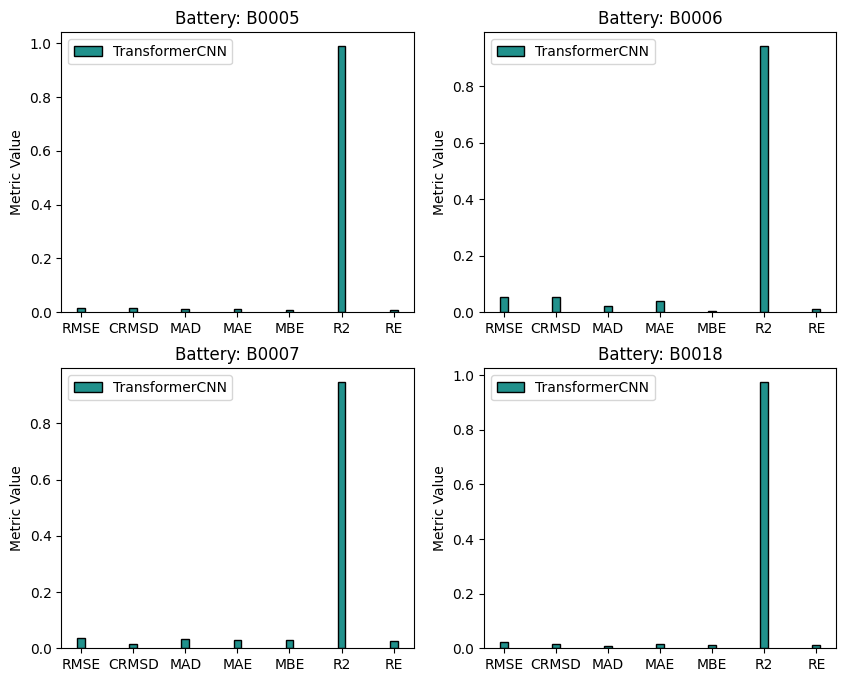

In [44]:
import seaborn as sns

# 绘制直方图
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

colors = sns.color_palette("viridis", n_colors=len(model_list))

for i, battery_name in enumerate(Battery_list):
    ax = axes[i]
    x = np.arange(len(metrics_list))
    width = 0.15  # 每个柱子的宽度

    for j, model_name in enumerate(model_list):
        try:
            metrics = model_metrics[model_name][battery_name]
            values = [metrics[metric_name] for metric_name in metrics_list]
            ax.bar(x + j * width, values, width, 
                   label=model_name, color=colors[j], edgecolor='black')
        except KeyError:
            print(f"Warning: Metrics not found for model \
                  {model_name} on battery {battery_name}")

    ax.set_xticks(x + width * (len(model_list) - 1) / 2)
    ax.set_xticklabels(metrics_list, ha="center")
    ax.set_ylabel('Metric Value')
    ax.set_title(f"Battery: {battery_name}")
    ax.legend()

plt.show()

In [46]:
# # 保存模型参数
# torch.save(model, 'NASA_TransformerCNN.pth')
# # 加载整个模型并进行预测
# model_loaded = torch.load('NASA_TransformerCNN.pth', map_location=torch.device(device))

### 3.4 模型预测

In [ ]:
window_size = 10 # 窗口大小
batch_size = 32 # 批训练大小
shuffle = True # 是否打乱数据集
head = 2

pred_list = []
for i in range(len(Battery_list)): # 四折交叉验证
    bat_name = Battery_list[i]
    _, test_loader, src_mask, tgt_mask = \
        get_data(capacity, bat_name, head, window_size, shuffle, batch_size)
    # 加载整个模型并进行预测
    model_loaded = torch.load('NASA_TransformerCNN.pth', map_location=torch.device(device))
    model_loaded = model_loaded.to(device) # 注册模型到设备

    model_loaded.eval() # 设置为验证模式
    test_pred = []
    with torch.no_grad():
        for index, batch in enumerate(iter(test_loader)):
            src, tgt = batch
            # 归一化
            src /= torch.tensor(Rated_Capacity).to(device)
            tgt /= torch.tensor(Rated_Capacity).to(device)
            pred = model_loaded(src, tgt, src_mask, tgt_mask)

            # 将预测值和真实值转换为 NumPy 数组并展平
            pred_np = (pred * Rated_Capacity).cpu().numpy().flatten()
            y_np = (tgt[:, -1, :] * Rated_Capacity).cpu().numpy().flatten()
            test_pred.extend(pred_np)
    pred_list.append(np.array(test_pred))

#### 3.4.1 绘制预测结果

In [ ]:
fig,ax = plt.subplots(2, 2, figsize=(16, 12))
for i in range(2):
    for j in range(2):
        t = i + j
        battery_name = Battery_list[t]
        test_data = capacity[battery_name][1].to_numpy()
        x = [t for t in range(len(test_data))]
        threshold = [Rated_Capacity*0.7] * len(test_data)
        ax[i][j].plot(x, test_data, 'c', label='test data')
        ax[i][j].plot(x[:window_size], test_data[:window_size], 'r', label='fixed data')
        ax[i][j].plot(x[window_size:], pred_list[t], 'b', label='predicted data')
        ax[i][j].plot(x, threshold, 'black', ls=':', label='border line')
        ax[i][j].legend()
        ax[i][j].set_xlabel('Discharge cycles', fontsize=15)
        ax[i][j].set_ylabel('Capacity (Ah)', fontsize=15)
        ax[i][j].set_title('test vs. prediction of battery ' + battery_name, fontsize=20)